In [1]:
# =============================================================================
# Cell 1: 导入所有必要的库
# =============================================================================
print("步骤 1/6: 正在导入所有必要的库...")

import pandas as pd
import numpy as np
import os
import qlib
from qlib.config import REG_CN
from qlib.data.dataset.handler import DataHandlerLP
from qlib.contrib.data.handler import check_transform_proc
from tqdm.auto import tqdm # 引入tqdm来显示进度条
import datetime as dt
import warnings
from typing import Optional, List, Tuple

warnings.filterwarnings("ignore")
print("库导入完成。\n")

步骤 1/6: 正在导入所有必要的库...
库导入完成。



In [ ]:
# =============================================================================
# Cell 2: 定义所有需要用户配置的路径和参数
# =============================================================================
print("步骤 2/6: 正在配置路径和参数...")

# !!! --- 用户需要修改的核心配置 --- !!!

# 1. 存放所有【独立Qlib数据仓库】的【根目录】
#    这个文件夹里面应该包含了 a9999.XDCE, ag9999.XSGE 等子文件夹
base_dir = os.path.dirname(os.path.abspath(__file__))

INDIVIDUAL_QLIB_BASE_PATH = os.path.join(base_dir, '../data/output/individual_qlibs_0708v3')

# 2. 您的 feature_test.txt 文件的【实际路径】
FEATURE_FILE_PATH = "./feature_test.txt"

# 3. 定义您要处理的时间范围
START_TIME = '2024-07-01 09:00:00'
END_TIME = '2024-12-31 15:30:00'
FIT_START_TIME = '2024-07-01 09:00:00'
FIT_END_TIME = '2024-12-31 15:15:00'

# 4. 定义存储文件尾缀
file_suffix = "1min"  

# !!! --- 配置结束 --- !!!

print(f"独立Qlib数据仓库根目录: {INDIVIDUAL_QLIB_BASE_PATH}")
print(f"特征文件路径: {FEATURE_FILE_PATH}")
print("路径和参数配置完成。\n")


步骤 2/6: 正在配置路径和参数...
独立Qlib数据仓库根目录: /Volumes/bk/CEF4_project/data/output/individual_qlibs_0708v3
特征文件路径: ./feature_test.txt
路径和参数配置完成。



In [3]:
# =============================================================================
# Cell 3: 定义 MASTERdata 类和处理器
# =============================================================================
print("步骤 3/6: 正在定义数据处理器类和配置...")

# 1. 定义处理器
_DEFAULT_SHARED_PROCESSORS = [{"class": "DropnaProcessor", "kwargs": {"fields_group": "feature"}},]
_DEFAULT_LEARN_PROCESSORS = [{"class": "DropnaProcessor"}, {"class": "DropnaLabel"},]
_DEFAULT_INFER_PROCESSORS = [{"class": "DropnaProcessor"},]

# 2. 定义您的 MASTERdata 类
class MASTERdata(DataHandlerLP):
    def __init__(
            self, instruments="all", features_list=None, labels=None, start_time=None, end_time=None,
            freq="1min", shared_processors=_DEFAULT_SHARED_PROCESSORS, infer_processors=_DEFAULT_INFER_PROCESSORS,
            learn_processors=_DEFAULT_LEARN_PROCESSORS, fit_start_time=None, fit_end_time=None,
            process_type=DataHandlerLP.PTYPE_I, **kwargs,
    ):
        shared_processors = check_transform_proc(shared_processors, fit_start_time, fit_end_time)
        infer_processors = check_transform_proc(infer_processors, fit_start_time, fit_end_time)
        learn_processors = check_transform_proc(learn_processors, fit_start_time, fit_end_time)
        dl_config = {
            "feature": self.get_feature_config(features_list),
            "label": self.get_label_config(labels),
        }
        data_loader = {"class": "QlibDataLoader", "kwargs": { "config": dl_config, "freq": freq },}
        super().__init__(
            instruments=instruments, start_time=start_time, end_time=end_time, data_loader=data_loader,
            shared_processors=shared_processors, infer_processors=infer_processors,
            learn_processors=learn_processors, process_type=process_type, **kwargs
        )
    # def get_label_config(self, labels):
    #     if not labels: return [], []
    #     return ([labels] if isinstance(labels, str) else labels, ['label'])
    def get_label_config(self, labels_config: dict):
        """
        这个新版本的方法现在期望接收一个字典。
        它会将字典的键作为列名（names），值作为表达式（expressions）。
        """
        # 检查输入是否为非空字典
        if not isinstance(labels_config, dict) or not labels_config:
            return [], []
        
        # 将字典的键和值分别提取为 names 和 expressions 列表
        expressions = list(labels_config.values())
        names = list(labels_config.keys())
        
        # Qlib Dataloader 需要一个包含两个列表的元组：(表达式列表, 名称列表)
        return (expressions, names)
    def get_feature_config(self, features_list):
        if not features_list: return [], []
        return features_list, features_list

print("数据处理器定义完成。\n")

步骤 3/6: 正在定义数据处理器类和配置...
数据处理器定义完成。



In [4]:
# =============================================================================
# Cell 4: 定义最终的核心处理与检查函数
# =============================================================================
print("步骤 4/6: 正在定义核心处理与检查函数...")

def process_with_individual_calendars(
    base_qlib_path: str,
    instrument_list: list,
    features_list: list,
    labels: str,
    start_time: str,
    end_time: str,
    fit_start_time: str,
    fit_end_time: str,
    output_csv_path: str = "calendar_check_results.csv"
) -> pd.DataFrame:
    
    all_processed_dfs = [] 
    calendar_check_results = []
    check_start_time = dt.time(10, 15)
    check_end_time = dt.time(10, 30)

    print(f"\n准备开始独立处理 {len(instrument_list)} 个资产...")
    
    for instrument_name in tqdm(instrument_list, desc="正在处理资产"):
        try:
            # --- 核心修改：为每个资产动态初始化Qlib ---
            instrument_qlib_dir = os.path.join(base_qlib_path, instrument_name)
            
            # 检查专属目录是否存在
            if not os.path.exists(instrument_qlib_dir):
                print(f"警告：找不到资产 {instrument_name} 的专属Qlib目录，跳过。路径: {instrument_qlib_dir}")
                calendar_check_results.append({"instrument": instrument_name, "has_1015_1030_trade": "Error: Directory not found"})
                continue
            
            # 强制Qlib使用当前资产的专属数据仓库
            qlib.init(provider_uri=instrument_qlib_dir, region=REG_CN)

            # --- 使用专属日历进行处理 ---
            handler_single = MASTERdata(
                instruments=[instrument_name], start_time=start_time, end_time=end_time,
                fit_start_time=fit_start_time, fit_end_time=fit_end_time,
                features_list=features_list, labels=labels,
            )
            
            has_trade_in_range = False
            df_single_processed = pd.DataFrame()
            
            if not handler_single._data.empty:
                inst_calendar = handler_single._data.index.get_level_values('datetime')
                if isinstance(inst_calendar, pd.DatetimeIndex):
                    inst_times = inst_calendar.time
                    has_trade_in_range = ((inst_times >= check_start_time) & (inst_times <= check_end_time)).any()
                df_single_processed = handler_single.fetch(data_key=DataHandlerLP.DK_L)
            
            calendar_check_results.append({"instrument": instrument_name, "has_1015_1030_trade": has_trade_in_range})

            if not df_single_processed.empty:
                all_processed_dfs.append(df_single_processed)
                
        except Exception as e:
            print(f"处理资产 {instrument_name} 时发生严重错误: {e}")
            if not any(d['instrument'] == instrument_name for d in calendar_check_results):
                 calendar_check_results.append({"instrument": instrument_name, "has_1015_1030_trade": f"Error: {type(e).__name__}"})
            continue

    # 保存日历检查结果到CSV
    if calendar_check_results:
        check_df = pd.DataFrame(calendar_check_results)
        check_df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
        print(f"\n日历检查结果已成功保存到: {output_csv_path}")
        print("检查结果预览:")
        print(check_df.head())

    # 合并所有处理好的数据
    if not all_processed_dfs:
        print("\n所有资产都未能成功处理，返回一个空的DataFrame。")
        return pd.DataFrame()

    print("\n所有资产独立处理完毕，正在将结果合并...")
    final_df = pd.concat(all_processed_dfs)
    print("数据合并完成！")
    return final_df

print("核心处理函数定义完成。\n")


步骤 4/6: 正在定义核心处理与检查函数...
核心处理函数定义完成。



In [5]:
# =============================================================================
# Cell 5: 加载资产列表、特征和标签
# =============================================================================
print("步骤 5/6: 正在加载资产列表、特征和标签...")

# 1. 从独立Qlib数据仓库的文件夹名自动加载资产列表
try:
    # 过滤掉macOS的隐藏文件
    all_instruments_to_process = [d for d in os.listdir(INDIVIDUAL_QLIB_BASE_PATH) if os.path.isdir(os.path.join(INDIVIDUAL_QLIB_BASE_PATH, d)) and not d.startswith('.')]
    print(f"成功从 {INDIVIDUAL_QLIB_BASE_PATH} 扫描到 {len(all_instruments_to_process)} 个资产目录。")
except FileNotFoundError:
    print(f"错误：找不到独立Qlib数据仓库的根目录 {INDIVIDUAL_QLIB_BASE_PATH}。请检查 Cell 2 中的路径配置。")
    all_instruments_to_process = []

步骤 5/6: 正在加载资产列表、特征和标签...
成功从 /Volumes/bk/CEF4_project/data/output/individual_qlibs_0708v3 扫描到 79 个资产目录。


In [6]:
import re
# 2. 从您的特征定义文件加载特征列表

try:
    with open(FEATURE_FILE_PATH, 'r') as f:
        # 首先加载所有原始特征
        all_features_original = [line.strip() for line in f if line.strip()]
    print(f"成功从 {FEATURE_FILE_PATH} 加载了 {len(all_features_original)} 个原始特征。")

    # --- 新增功能：筛选特征 ---
    print("\n开始根据回看周期筛选特征...")

    # 定义一个正则表达式模式，用于匹配以 ", 60)" 结尾的算子
    # 例如：Mean($close, 60), Corr($open, $close, 60)
    # 这样可以精确匹配窗口期为60的算子，同时避免错误匹配 "160" 等
    pattern_to_remove = re.compile(r",\s*60\s*\)")

    # 使用列表推导式进行筛选
    features_list_filtered = [
        feature_str for feature_str in all_features_original
        if not pattern_to_remove.search(feature_str)
    ]
    
    # 为了方便您检查，我们也可以找出被移除了哪些特征
    features_removed = [
        feature_str for feature_str in all_features_original
        if pattern_to_remove.search(feature_str)
    ]

    print("\n" + "="*20 + " 筛选结果 " + "="*20)
    print(f"原始特征数量: {len(all_features_original)}")
    print(f"因回看周期为60而被移除的特征数量: {len(features_removed)}")
    print(f"筛选后剩余特征数量: {len(features_list_filtered)}")
    
    if features_removed:
        print("\n被移除的特征示例（最多显示5个）:")
        for feature in features_removed[:5]:
            print(f" - {feature}")
    
    # 将筛选后的列表赋值给最终要使用的变量
    features_list_1 = features_list_filtered
    print("\n特征筛选完成！")

except FileNotFoundError:
    print(f"错误：无法在 {FEATURE_FILE_PATH} 找到特征文件。请检查路径配置。")
    features_list_1 = []

成功从 ./feature_test.txt 加载了 158 个原始特征。

开始根据回看周期筛选特征...

==================== 筛选结果 ====================
原始特征数量: 158
因回看周期为60而被移除的特征数量: 27
筛选后剩余特征数量: 131

被移除的特征示例（最多显示5个）:
 - Ref($close, 60)/$close
 - Mean($close, 60)/$close
 - Std($close, 60)/$close
 - Slope($close, 60)/$close
 - Rsquare($close, 60)

特征筛选完成！


In [7]:
# 3. 定义标签
# =============================================================================
# 调整部分 1: 定义包含所有标签及其名称的配置字典
# =============================================================================

# 使用字典来定义多个标签
# 键 (key) 将成为最终的列名，值 (value) 是对应的Qlib表达式
labels_config = {
    # 基于 vwap 的标签
    'label_vwap_2m': 'Ref($vwap, -2)/Ref($vwap, -1) - 1',
    'label_vwap_5m': 'Ref($vwap, -5)/Ref($vwap, -1) - 1',
    # 'label_vwap_10m': 'Ref($vwap, -10)/Ref($vwap, -1) - 1',
    # 'label_vwap_15m': 'Ref($vwap, -15)/Ref($vwap, -1) - 1',
    
    # 基于 close/open 的标签
    'label_co_2m': 'Ref($close, -2)/Ref($open, -1) - 1',
    'label_co_5m': 'Ref($close, -5)/Ref($open, -1) - 1',
    # 'label_co_10m': 'Ref($close, -10)/Ref($open, -1) - 1',
    # 'label_co_15m': 'Ref($close, -15)/Ref($open, -1) - 1',
}

print(f"成功定义了 {len(labels_config)} 个标签。")

# (原来的 features_list_1 和其他变量定义保持不变)

成功定义了 4 个标签。


In [8]:
# =============================================================================
# Cell 6: 执行最终的处理流程
# =============================================================================
print("步骤 6/6: 正在执行数据处理流程...")

if all_instruments_to_process and features_list_1:
    
    final_data = process_with_individual_calendars(
        base_qlib_path=INDIVIDUAL_QLIB_BASE_PATH,
        instrument_list=all_instruments_to_process,
        features_list=features_list_1,
        labels=labels_config, # <-- 关键修改在这里，使用新的字典
        start_time=START_TIME,
        end_time=END_TIME,
        fit_start_time=FIT_START_TIME,
        fit_end_time=FIT_END_TIME,
        output_csv_path="final_calendar_check.csv"
    )

    print("\n" + "="*20 + " 最终结果 " + "="*20)
    if not final_data.empty:
        print("\n最终合并后的数据形状:", final_data.shape)
        print("最终合并后的数据预览:")
        print(final_data.head())
    else:
        print("\n处理流程结束，但没有生成任何数据。")
else:
    print("\n因为缺少资产列表或特征列表，无法开始处理流程。请检查 Cell 2 和 Cell 5 中的文件路径与错误信息。")

步骤 6/6: 正在执行数据处理流程...

准备开始独立处理 79 个资产...


正在处理资产:   0%|          | 0/79 [00:00<?, ?it/s]

[24849:MainThread](2025-07-08 14:05:22,759) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[24849:MainThread](2025-07-08 14:05:22,959) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[24849:MainThread](2025-07-08 14:05:22,959) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/Volumes/bk/CEF4_project/data/output/individual_qlibs_0708v3/SP9999.XSGE')}
[24849:MainThread](2025-07-08 14:05:23,525) INFO - qlib.timer - [log.py:127] - Time cost: 0.565s | Loading data Done
[24849:MainThread](2025-07-08 14:05:23,540) INFO - qlib.timer - [log.py:127] - Time cost: 0.015s | DropnaProcessor Done
[24849:MainThread](2025-07-08 14:05:23,554) INFO - qlib.timer - [log.py:127] - Time cost: 0.014s | DropnaProcessor Done
[24849:MainThread](2025-07-08 14:05:23,567) INFO - qlib.timer - [log.py:127] - Time cost: 0.012s | DropnaProcessor Done
[24849:MainThread](2025-07-08 14:05:23,569) INFO - qli


日历检查结果已成功保存到: final_calendar_check.csv
检查结果预览:
    instrument  has_1015_1030_trade
0  SP9999.XSGE                 True
1  CJ9999.XZCE                 True
2  ZC9999.XZCE                 True
3  IC9999.CCFX                 True
4  RU9999.XSGE                 True

所有资产独立处理完毕，正在将结果合并...
数据合并完成！

==================== 最终结果 ====================

最终合并后的数据形状: (2854432, 135)
最终合并后的数据预览:
                                 ($close-$open)/$open  ($high-$low)/$open  \
datetime            instrument                                              
2024-07-01 09:31:00 SP9999.XSGE              0.000676            0.001014   
2024-07-01 09:32:00 SP9999.XSGE             -0.000338            0.000675   
2024-07-01 09:33:00 SP9999.XSGE             -0.000675            0.001013   
2024-07-01 09:34:00 SP9999.XSGE              0.000000            0.000676   
2024-07-01 09:35:00 SP9999.XSGE             -0.000676            0.001014   

                                 ($close-$open)/($high-$low+1e-12)  \
datetim

In [9]:
final_data

,,($close-$open)/$open,($high-$low)/$open,($close-$open)/($high-$low+1e-12),"($high-Greater($open, $close))/$open","($high-Greater($open, $close))/($high-$low+1e-12)","(Less($open, $close)-$low)/$open","(Less($open, $close)-$low)/($high-$low+1e-12)",(2*$close-$high-$low)/$open,(2*$close-$high-$low)/($high-$low+1e-12),$open/$close,...,"Sum(Greater(Ref($volume, 1)-$volume, 0), 20)/(Sum(Abs($volume-Ref($volume, 1)), 20)+1e-12)","Sum(Greater(Ref($volume, 1)-$volume, 0), 30)/(Sum(Abs($volume-Ref($volume, 1)), 30)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 5)-Sum(Greater(Ref($volume, 1)-$volume, 0), 5))/(Sum(Abs($volume-Ref($volume, 1)), 5)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 10)-Sum(Greater(Ref($volume, 1)-$volume, 0), 10))/(Sum(Abs($volume-Ref($volume, 1)), 10)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 20)-Sum(Greater(Ref($volume, 1)-$volume, 0), 20))/(Sum(Abs($volume-Ref($volume, 1)), 20)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 30)-Sum(Greater(Ref($volume, 1)-$volume, 0), 30))/(Sum(Abs($volume-Ref($volume, 1)), 30)+1e-12)",label_vwap_2m,label_vwap_5m,label_co_2m,label_co_5m
datetime,instrument,,,,,,,,,,,,,,,,,,,,,
2024-07-01 09:31:00,SP9999.XSGE,0.000676,0.001014,0.666667,0.000000,0.000000,0.000338,0.333333,0.001014,1.000000,0.999325,...,0.494099,0.496876,-0.059431,0.066659,0.011802,0.006248,0.000174,-0.001180,-0.000675,-0.001689
2024-07-01 09:32:00,SP9999.XSGE,-0.000338,0.000675,-0.500000,0.000000,0.000000,0.000338,0.500000,0.000000,0.000000,1.000338,...,0.511332,0.506615,-0.026114,0.012446,-0.022664,-0.013230,-0.000376,-0.001594,-0.000675,-0.001351
2024-07-01 09:33:00,SP9999.XSGE,-0.000675,0.001013,-0.666667,0.000338,0.333333,0.000000,0.000000,-0.001013,-1.000000,1.000676,...,0.524324,0.506071,-0.757862,0.070342,-0.048649,-0.012141,-0.000856,-0.001710,-0.000676,-0.002028
2024-07-01 09:34:00,SP9999.XSGE,0.000000,0.000676,0.000000,0.000676,1.000000,0.000000,0.000000,-0.000676,-1.000000,1.000000,...,0.554755,0.512800,-0.511032,-0.033590,-0.109511,-0.025600,-0.000122,-0.000928,-0.001014,-0.001352
2024-07-01 09:35:00,SP9999.XSGE,-0.000676,0.001014,-0.666667,0.000000,0.000000,0.000338,0.333333,-0.000338,-0.333333,1.000676,...,0.534236,0.515083,-0.247661,0.113309,-0.068473,-0.030166,-0.000241,-0.000194,0.000000,-0.000338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 14:51:00,L9999.XDCE,-0.000245,0.000367,-0.666667,0.000122,0.333333,0.000000,0.000000,-0.000367,-1.000000,1.000245,...,0.456048,0.485407,0.352244,0.318264,0.087905,0.029185,-0.000025,-0.000457,-0.000734,-0.000979
2024-12-31 14:52:00,L9999.XDCE,-0.000612,0.000856,-0.714286,0.000000,0.000000,0.000245,0.285714,-0.000367,-0.428571,1.000612,...,0.449782,0.440313,0.367683,0.353629,0.100436,0.119374,-0.000362,-0.000471,-0.000734,-0.000490
2024-12-31 14:53:00,L9999.XDCE,-0.000245,0.000245,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.000245,-1.000000,1.000245,...,0.513570,0.496029,0.029551,0.041995,-0.027140,0.007941,-0.000030,0.000028,-0.000122,-0.000245


In [10]:
final_data.isnull().sum().sum()  # 检查是否有缺失值

0

In [11]:
final_data_new = final_data.reset_index()

In [12]:
final_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854432 entries, 0 to 2854431
Columns: 137 entries, datetime to label_co_5m
dtypes: datetime64[ns](1), float32(135), object(1)
memory usage: 1.5+ GB


中文/符号字体设置成功。
开始处理数据...
数据处理完毕！

==================== 用于绘图的统计数据 ====================
         time       mean       std   max   min       time_for_plot
0    00:00:00  11.532787  0.694541  12.0   9.0 1900-01-01 00:00:00
1    00:01:00  11.565574  0.616411  12.0   9.0 1900-01-01 00:01:00
2    00:02:00  11.622951  0.659675  12.0   9.0 1900-01-01 00:02:00
3    00:03:00  11.672131  0.566891  12.0  10.0 1900-01-01 00:03:00
4    00:04:00  11.680328  0.549476  12.0  10.0 1900-01-01 00:04:00
5    00:05:00  11.606557  0.624002  12.0  10.0 1900-01-01 00:05:00
6    00:06:00  11.524590  0.670674  12.0   9.0 1900-01-01 00:06:00
7    00:07:00  11.483607  0.645821  12.0  10.0 1900-01-01 00:07:00
8    00:08:00  11.450820  0.693565  12.0   9.0 1900-01-01 00:08:00
9    00:09:00  11.450820  0.669309  12.0   9.0 1900-01-01 00:09:00
10   00:10:00  11.483607  0.658493  12.0  10.0 1900-01-01 00:10:00
11   00:11:00  11.565574  0.616411  12.0  10.0 1900-01-01 00:11:00
12   00:12:00  11.508197  0.707059  12.0  10.

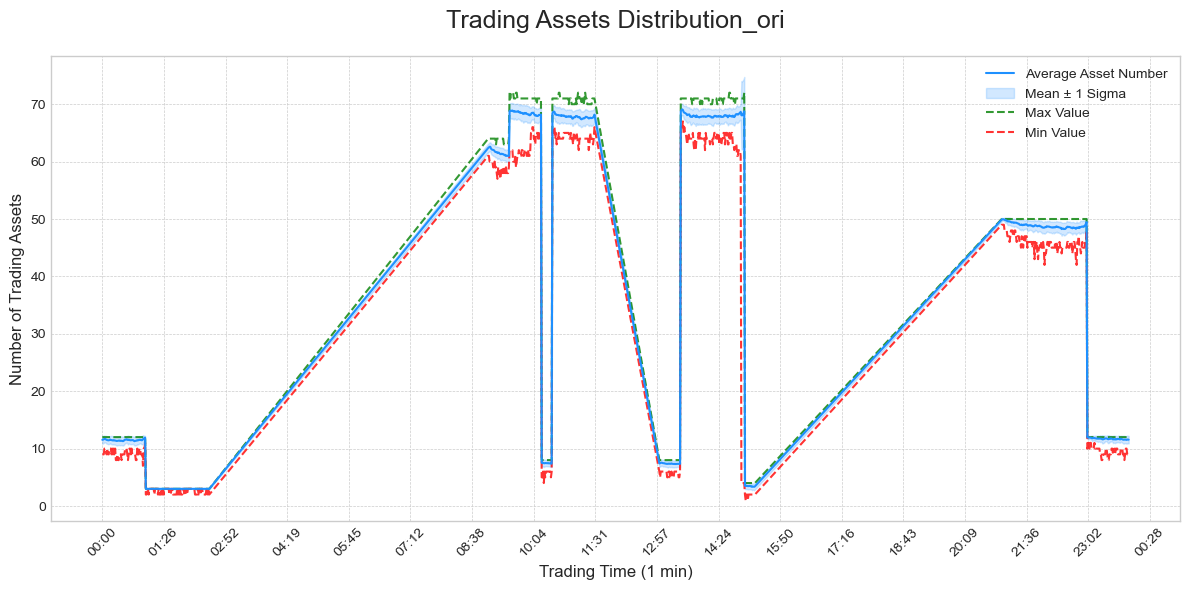

图表绘制完成！


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional

def plot_trading_assets_distribution(
    df: pd.DataFrame,
    datetime_col: str = 'datetime',
    instrument_col: str = 'instrument',
    title: str = 'Distribution of Trading Assets per Minute',
    figsize: tuple = (18, 9)
) -> None:
    """
    计算并绘制每日内每分钟的平均、最大、最小交易资产数量。

    此函数会分析一个包含时间序列数据的DataFrame，统计在每个交易时刻（如09:31, 09:32）
    于所有日期中交易资产数量的统计信息，并以图表形式展示。
    (此版本已为macOS优化中文显示，并增加了最大/最小值和数据打印功能)

    参数:
    ----------
    df : pd.DataFrame
        输入的DataFrame，必须包含一个时间列和一个资产标识列。
        
    datetime_col : str, optional
        DataFrame中表示完整日期和时间的列名，默认为'datetime'。
        
    instrument_col : str, optional
        DataFrame中表示交易资产（如股票代码）的列名，默认为'instrument'。
        
    title : str, optional
        图表的标题。
        
    figsize : tuple, optional
        图表的尺寸。

    返回:
    -------
    None
        此函数会直接显示生成的图表并打印统计数据。
    """
    
    # --- 中文显示解决方案 for macOS ---
    try:
        # 您可以使用 'PingFang SC' 或 'SimHei' 等您系统中存在的中文字体
        plt.rcParams['font.sans-serif'] = ['SimHei'] 
        plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
        print("中文/符号字体设置成功。")
    except Exception as e:
        print(f"中文字体设置失败: {e}。图表中的中文可能无法正常显示。")
    # --- 中文显示解决方案结束 ---

    if not isinstance(df, pd.DataFrame) or df.empty:
        print("输入的DataFrame为空或无效。")
        return
    if datetime_col not in df.columns or instrument_col not in df.columns:
        print(f"错误: DataFrame中必须包含 '{datetime_col}' 和 '{instrument_col}' 列。")
        return

    print("开始处理数据...")
    temp_df = df[[datetime_col, instrument_col]].copy()

    temp_df['date'] = pd.to_datetime(temp_df[datetime_col]).dt.date
    temp_df['time'] = pd.to_datetime(temp_df[datetime_col]).dt.time

    daily_counts_per_minute = temp_df.groupby(['date', 'time'])[instrument_col].nunique()
    stats_calculator_df = daily_counts_per_minute.unstack(level='date')
    
    # --- 功能新增 (1): 计算最大值和最小值 ---
    mean_counts = stats_calculator_df.mean(axis=1)
    std_counts = stats_calculator_df.std(axis=1)
    max_counts = stats_calculator_df.max(axis=1)
    min_counts = stats_calculator_df.min(axis=1)
    
    if mean_counts.empty:
        print("计算后没有得到有效数据，无法绘图。请检查输入数据的datetime范围和内容。")
        return

    # 将所有统计数据合并到一个DataFrame中
    stats_df = pd.DataFrame({
        'mean': mean_counts,
        'std': std_counts,
        'max': max_counts,
        'min': min_counts
    }).reset_index()

    stats_df['time_for_plot'] = pd.to_datetime(stats_df['time'].astype(str), format='%H:%M:%S')
    print("数据处理完毕！")
    
    # --- 功能新增 (2): 打印用于绘图的DataFrame ---
    print("\n" + "="*20 + " 用于绘图的统计数据 " + "="*20)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 120):
        print(stats_df)
    print("="*62 + "\n")


    print("正在绘制图表...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=figsize)

    # 绘制均值线
    ax.plot(stats_df['time_for_plot'], stats_df['mean'], color='dodgerblue', label='Average Asset Number', zorder=3)
    
    # 绘制标准差区间
    ax.fill_between(
        stats_df['time_for_plot'],
        stats_df['mean'] - stats_df['std'],
        stats_df['mean'] + stats_df['std'],
        color='dodgerblue',
        alpha=0.2,
        label='Mean ± 1 Sigma',
        zorder=1
    )
    
    # --- 功能新增 (1): 绘制最大值和最小值线 ---
    ax.plot(stats_df['time_for_plot'], stats_df['max'], color='green', linestyle='--', label='Max Value', alpha=0.8, zorder=2)
    ax.plot(stats_df['time_for_plot'], stats_df['min'], color='red', linestyle='--', label='Min Value', alpha=0.8, zorder=2)


    # --- 图表格式化 ---
    ax.set_title(title, fontsize=18, pad=20)
    ax.set_xlabel('Trading Time (1 min)', fontsize=12)
    ax.set_ylabel('Number of Trading Assets', fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)

    ax.legend(loc='best')
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    fig.tight_layout()
    plt.show()
    print("图表绘制完成！")


plot_trading_assets_distribution(final_data_new, figsize=(12, 6), title="Trading Assets Distribution_ori")

## 处理跳空

In [14]:
import os
import pandas as pd
from importlib.machinery import SourceFileLoader

# --- 用户需要确认的路径 ---

# 1. 存放所有【独立Qlib数据仓库】的【根目录】
#    这个路径应该和您上一步运行代码时使用的路径一致
QLIB_BASE_PATH = "/Volumes/bk/CEF4_project/data/output/individual_qlibs_0708v3"

# 2. 您的 trading_time.py 文件的实际路径
TRADING_HOURS_PATH = "trading_time.py"

# --- 核心检查逻辑 ---

def find_missing_instruments(qlib_path: str, trading_hours_file: str):
    """
    比较Qlib数据目录中的所有资产与交易时间文件中定义的资产，找出差异。
    """
    print("开始检查缺失的资产...")
    
    # 1. 获取数据仓库中的所有资产列表
    try:
        # 通过扫描文件夹名来获取最准确的资产全集
        all_instruments_set = {
            d for d in os.listdir(qlib_path)
            if os.path.isdir(os.path.join(qlib_path, d)) and not d.startswith('.')
        }
        if not all_instruments_set:
            print(f"错误：在目录 '{qlib_path}' 中没有找到任何资产子文件夹。")
            return
        print(f"在您的数据仓库中找到了 {len(all_instruments_set)} 个资产。")
    except FileNotFoundError:
        print(f"错误：找不到Qlib数据仓库根目录 '{qlib_path}'。请检查路径。")
        return

    # 2. 从 trading_time.py 文件中加载已定义的资产列表
    try:
        trading_time_module = SourceFileLoader("trading_time", trading_hours_file).load_module()
        defined_instruments_set = set(trading_time_module.contract_trading_hours.keys())
        print(f"在 '{trading_hours_file}' 文件中找到了 {len(defined_instruments_set)} 个已定义交易时间的资产。")
    except FileNotFoundError:
        print(f"错误：找不到交易时间文件 '{trading_hours_file}'。请检查路径。")
        return
    except Exception as e:
        print(f"加载交易时间文件时出错: {e}")
        return
        
    # 3. 使用集合的差集运算，找出缺失的资产
    missing_instruments = all_instruments_set - defined_instruments_set
    
    # 4. 打印结果
    print("\n" + "="*20 + " 检查结果 " + "="*20)
    if missing_instruments:
        print(f"发现 {len(missing_instruments)} 个资产存在于您的数据中，但在 'trading_time.py' 文件里【缺失】了定义：")
        # 将集合转换为列表以便于复制
        print(list(missing_instruments))
    else:
        print("恭喜！您的 'trading_time.py' 文件包含了所有资产的定义，没有缺失。")
    print("="*52)


# --- 执行检查 ---
find_missing_instruments(qlib_path=QLIB_BASE_PATH, trading_hours_file=TRADING_HOURS_PATH)

开始检查缺失的资产...
在您的数据仓库中找到了 79 个资产。
在 'trading_time.py' 文件中找到了 79 个已定义交易时间的资产。

==================== 检查结果 ====================
恭喜！您的 'trading_time.py' 文件包含了所有资产的定义，没有缺失。


In [15]:
import pandas as pd
import numpy as np
import datetime as dt
from typing import Dict, List, Tuple

def filter_trading_data_by_session(
    df: pd.DataFrame,
    trading_hours_path: str,
    datetime_col: str = 'datetime',
    instrument_col: str = 'instrument'
) -> pd.DataFrame:
    """
    根据每个资产独特的交易时段，筛选DataFrame，移除每个时段的头部和尾部数据。

    规则:
    1. 移除每个交易时段开始的第一个小时的数据。
    2. 移除每个交易时段结束的最后两分钟的数据。

    参数:
    ----------
    df : pd.DataFrame
        包含所有资产数据的DataFrame，需要有时间和资产标识列。
        
    trading_hours_path : str
        包含`contract_trading_hours`字典的 .py 文件路径。
        
    datetime_col : str
        DataFrame中表示完整日期和时间的列名。
        
    instrument_col : str
        DataFrame中表示交易资产的列名。
        
    返回:
    -------
    pd.DataFrame
        一个经过精确筛选后的新DataFrame。
    """
    
    # --- 1. 动态加载交易时间配置 ---
    try:
        from importlib.machinery import SourceFileLoader
        trading_time_module = SourceFileLoader("trading_time", trading_hours_path).load_module()
        contract_trading_hours = trading_time_module.contract_trading_hours
        print(f"成功从 '{trading_hours_path}' 加载了 {len(contract_trading_hours)} 个资产的交易时间。")
    except Exception as e:
        print(f"错误：无法从 '{trading_hours_path}' 加载交易时间配置。请检查路径。错误信息: {e}")
        return pd.DataFrame()

    # --- 2. 预处理和辅助函数 ---
    
    # 确保datetime列是datetime类型
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    def parse_time_sessions(session_str: str) -> List[Tuple[dt.time, dt.time]]:
        """解析交易时间的字符串（例如 "09:00-11:30, 13:30-15:00"）"""
        if not session_str or session_str == "无":
            return []
        sessions = []
        parts = session_str.split(',')
        for part in parts:
            # *** 核心修改点：使用 .strip() 清除前后多余的空格 ***
            clean_part = part.strip()
            if not clean_part:
                continue
            
            start_str, end_str = clean_part.split('-')
            
            # 这里也加上 .strip() 以确保万无一失
            start_time = dt.datetime.strptime(start_str.strip(), '%H:%M').time()
            end_time = dt.datetime.strptime(end_str.strip(), '%H:%M').time()
            sessions.append((start_time, end_time))
        return sessions

    # --- 3. 核心筛选逻辑 ---
    
    print("开始根据交易时段筛选数据...")
    
    filtered_dfs = []
    
    for instrument, group_df in df.groupby(instrument_col):
        if instrument not in contract_trading_hours:
            filtered_dfs.append(group_df)
            continue
        
        sessions_info = contract_trading_hours[instrument]
        day_sessions = parse_time_sessions(sessions_info.get("day", ""))
        night_sessions = parse_time_sessions(sessions_info.get("night", ""))
        
        mask_to_keep = pd.Series(False, index=group_df.index)
        
        for start_time, end_time in day_sessions + night_sessions:
            filter_start = (dt.datetime.combine(dt.date.min, start_time) + dt.timedelta(minutes=30)).time()
            filter_end = (dt.datetime.combine(dt.date.min, end_time) - dt.timedelta(minutes=5)).time()
            
            current_times = group_df[datetime_col].dt.time
            
            if start_time > end_time: # 夜盘跨天
                session_mask = (current_times >= filter_start) | (current_times <= filter_end)
            else: # 日盘或不跨天的夜盘
                session_mask = (current_times >= filter_start) & (current_times <= filter_end)
            
            mask_to_keep |= session_mask
            
        filtered_dfs.append(group_df[mask_to_keep])

    print("数据筛选完成，正在合并结果...")
    
    # --- 4. 合并结果 ---
    if not filtered_dfs:
        print("筛选后没有剩下任何数据。")
        return pd.DataFrame()
        
    final_filtered_df = pd.concat(filtered_dfs).reset_index(drop=True)
    
    print("所有操作完成！")
    return final_filtered_df

trading_hours_file_path = "trading_time.py"

final_filtered_df= filter_trading_data_by_session(
    df=final_data_new,
    trading_hours_path=trading_hours_file_path,
    datetime_col='datetime',
    instrument_col='instrument')

成功从 'trading_time.py' 加载了 79 个资产的交易时间。
开始根据交易时段筛选数据...
数据筛选完成，正在合并结果...
所有操作完成！


In [16]:
final_filtered_df

,datetime,instrument,($close-$open)/$open,($high-$low)/$open,($close-$open)/($high-$low+1e-12),"($high-Greater($open, $close))/$open","($high-Greater($open, $close))/($high-$low+1e-12)","(Less($open, $close)-$low)/$open","(Less($open, $close)-$low)/($high-$low+1e-12)",(2*$close-$high-$low)/$open,...,"Sum(Greater(Ref($volume, 1)-$volume, 0), 20)/(Sum(Abs($volume-Ref($volume, 1)), 20)+1e-12)","Sum(Greater(Ref($volume, 1)-$volume, 0), 30)/(Sum(Abs($volume-Ref($volume, 1)), 30)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 5)-Sum(Greater(Ref($volume, 1)-$volume, 0), 5))/(Sum(Abs($volume-Ref($volume, 1)), 5)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 10)-Sum(Greater(Ref($volume, 1)-$volume, 0), 10))/(Sum(Abs($volume-Ref($volume, 1)), 10)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 20)-Sum(Greater(Ref($volume, 1)-$volume, 0), 20))/(Sum(Abs($volume-Ref($volume, 1)), 20)+1e-12)","(Sum(Greater($volume-Ref($volume, 1), 0), 30)-Sum(Greater(Ref($volume, 1)-$volume, 0), 30))/(Sum(Abs($volume-Ref($volume, 1)), 30)+1e-12)",label_vwap_2m,label_vwap_5m,label_co_2m,label_co_5m
0,2024-07-01 09:31:00,A9999.XDCE,0.000000,0.000641,0.000000,0.000427,0.666667,0.000214,0.333333,-0.000214,...,0.501215,0.573748,-0.020262,-0.144690,-0.002430,-0.147495,-0.000399,-0.000756,-0.000641,-0.000427
1,2024-07-01 09:32:00,A9999.XDCE,-0.000427,0.000855,-0.500000,0.000214,0.250000,0.000214,0.250000,-0.000427,...,0.497888,0.514581,-0.086984,-0.030303,0.004223,-0.029162,0.000079,0.000352,-0.000214,0.000214
2,2024-07-01 09:33:00,A9999.XDCE,0.000000,0.000214,0.000000,0.000000,0.000000,0.000214,1.000000,0.000214,...,0.496064,0.557604,-0.022434,0.068624,0.007872,-0.115207,-0.000911,-0.000252,-0.001283,-0.000214
3,2024-07-01 09:34:00,A9999.XDCE,-0.000214,0.000428,-0.500000,0.000214,0.500000,0.000000,0.000000,-0.000428,...,0.534965,0.538174,-0.509108,-0.094878,-0.069930,-0.076347,0.000476,0.000287,0.000428,-0.000428
4,2024-07-01 09:35:00,A9999.XDCE,-0.001070,0.001283,-0.833333,0.000214,0.166667,0.000000,0.000000,-0.001283,...,0.616291,0.475248,0.393227,0.291005,-0.232582,0.049505,0.000709,-0.000067,0.001499,0.000857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045962,2024-12-31 14:51:00,ZN9999.XSGE,0.000197,0.000590,0.333333,0.000197,0.333333,0.000197,0.333333,0.000197,...,0.605405,0.519599,-0.278196,0.174876,-0.210811,-0.039197,-0.000021,0.000689,0.000000,0.000197
2045963,2024-12-31 14:52:00,ZN9999.XSGE,-0.000197,0.000590,-0.333333,0.000000,0.000000,0.000393,0.666667,0.000197,...,0.560238,0.481574,0.457541,0.131717,-0.120475,0.036853,0.000639,0.000254,0.000786,0.000590
2045964,2024-12-31 14:53:00,ZN9999.XSGE,0.000393,0.000590,0.666667,0.000000,0.000000,0.000197,0.333333,0.000590,...,0.494881,0.488038,0.085622,0.111111,0.010239,0.023925,0.000249,0.000032,0.000589,0.000393
2045965,2024-12-31 14:54:00,ZN9999.XSGE,0.000197,0.000393,0.500000,0.000000,0.000000,0.000197,0.500000,0.000393,...,0.480370,0.561017,0.527273,-0.119682,0.039259,-0.122034,-0.000178,-0.000134,-0.000196,0.000000


中文/符号字体设置成功。
开始处理数据...
数据处理完毕！

==================== 用于绘图的统计数据 ====================
         time       mean       std   max   min       time_for_plot
0    00:00:00  11.532787  0.694541  12.0   9.0 1900-01-01 00:00:00
1    00:01:00  11.565574  0.616411  12.0   9.0 1900-01-01 00:01:00
2    00:02:00  11.622951  0.659675  12.0   9.0 1900-01-01 00:02:00
3    00:03:00  11.672131  0.566891  12.0  10.0 1900-01-01 00:03:00
4    00:04:00  11.680328  0.549476  12.0  10.0 1900-01-01 00:04:00
5    00:05:00  11.606557  0.624002  12.0  10.0 1900-01-01 00:05:00
6    00:06:00  11.524590  0.670674  12.0   9.0 1900-01-01 00:06:00
7    00:07:00  11.483607  0.645821  12.0  10.0 1900-01-01 00:07:00
8    00:08:00  11.450820  0.693565  12.0   9.0 1900-01-01 00:08:00
9    00:09:00  11.450820  0.669309  12.0   9.0 1900-01-01 00:09:00
10   00:10:00  11.483607  0.658493  12.0  10.0 1900-01-01 00:10:00
11   00:11:00  11.565574  0.616411  12.0  10.0 1900-01-01 00:11:00
12   00:12:00  11.508197  0.707059  12.0  10.

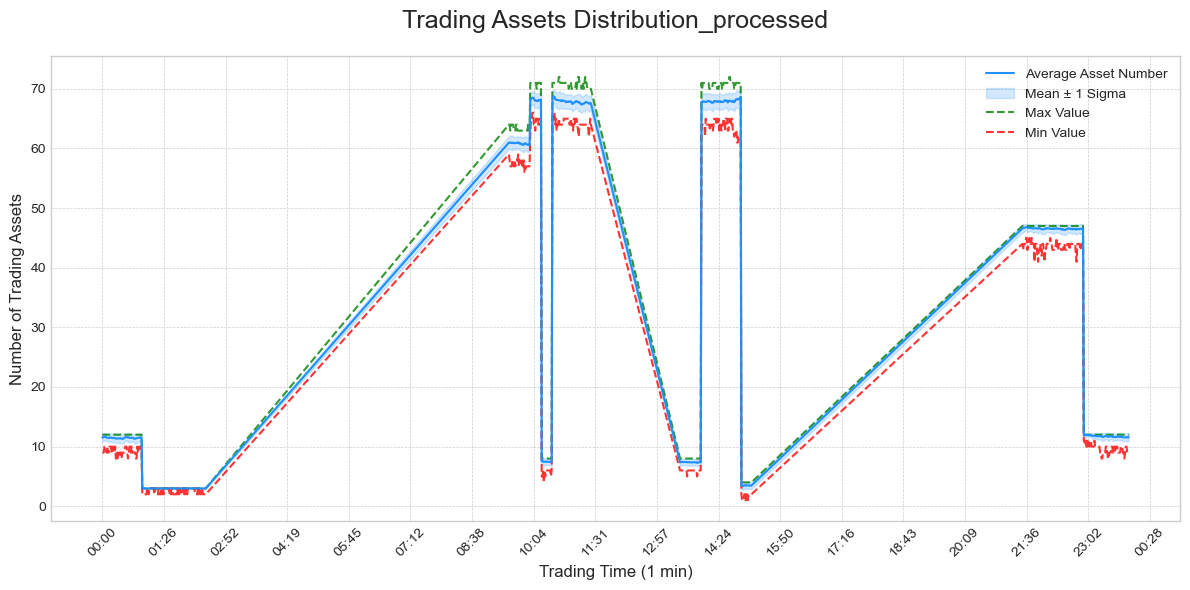

图表绘制完成！


In [17]:
plot_trading_assets_distribution(final_filtered_df, figsize=(12, 6), title="Trading Assets Distribution_processed")

In [18]:
final_filtered_df.to_parquet(f"../data/output/final_filtered_data_{file_suffix}_0708v3.parquet")